# Classification without missing labels
## Import full data

In [1]:
import numpy as np
import pandas as pd
import json 
import imblearn

In [2]:
from sklearn.manifold import Isomap, TSNE, MDS, LocallyLinearEmbedding
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
All = pd.read_json('data_and_meta.json')
All.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232748 entries, 0 to 284530
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           232748 non-null  int64 
 1   reviewerID      232748 non-null  object
 2   asin            232748 non-null  object
 3   reviewerName    230910 non-null  object
 4   helpful         232748 non-null  object
 5   reviewText      232748 non-null  object
 6   overall         232748 non-null  int64 
 7   summary         232748 non-null  object
 8   unixReviewTime  232748 non-null  int64 
 9   reviewTime      232748 non-null  object
 10  features        232748 non-null  object
 11  amazonCategory  232748 non-null  object
 12  class           19918 non-null   object
 13  title           106284 non-null  object
 14  description     232748 non-null  object
 15  feature         232748 non-null  object
dtypes: int64(3), object(13)
memory usage: 30.2+ MB


In [11]:
All.dropna(inplace=True)

In [12]:
from sklearn import preprocessing
#categorical = ['class']
#le = preprocessing.LabelEncoder()
#All[categorical] = All[categorical].apply(lambda series: pd.Series(
#    le.fit_transform(series[series.notnull()]),
#    index=series[series.notnull()].index
#))

In [14]:
categorical = ['class']  
le = preprocessing.LabelEncoder()
All['target'] = le.fit_transform(All['class']) 

In [18]:
All.drop(All.loc[All['target']==0].index, inplace=True)
All.groupby('target').size()

target
1    7991
2    9500
dtype: int64

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
All.head(2)

,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,features,amazonCategory,class,title,description,feature,target
208899,169986,A1BD4T41QJZBHB,B00001YVG4,E-Man,"[2, 2]","Mine was manufactured in March 1996, and accor...",5,Still Humming After All These Years,1252022400,"09 4, 2009","[-0.0909284763, 0.1879815474, 0.3447556303, -0...",electronics,1,Sony KV-9PT50 9&quot; Trinitron TV,This compact TV features a 9-inch screen house...,9-inch Trinitron picture tube Dual-mode bracke...,1
208901,169987,A7Y6AVS576M03,B00001YVG4,gobirds2,"[9, 10]",This is one of the finest `nine-inch' TVs from...,5,Precisely Perfect Picture Fidelity,988588800,"04 30, 2001","[-0.1457103733, 0.20106421160000001, 0.3179189...",electronics,1,Sony KV-9PT50 9&quot; Trinitron TV,This compact TV features a 9-inch screen house...,9-inch Trinitron picture tube Dual-mode bracke...,1


## Applying TF-IDF:

In [24]:
%%time

X_ = All['reviewText']
y_ = All['target']

pipe = Pipeline([('vectorizer', CountVectorizer()),  
                 ('tfidf', TfidfTransformer()), 
                 ('classifier', RandomForestClassifier(n_jobs=5, max_depth=13))])
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)

classifier = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.98      0.94      2654
           2       0.98      0.90      0.94      3119

    accuracy                           0.94      5773
   macro avg       0.94      0.94      0.94      5773
weighted avg       0.94      0.94      0.94      5773

CPU times: user 3.27 s, sys: 39.5 ms, total: 3.31 s
Wall time: 1.94 s


In [25]:
confusion_matrix(y_test, y_pred)

array([[2607,   47],
       [ 304, 2815]])

Confusion matrix, without normalization
[[2607   47]
 [ 304 2815]]
Normalized confusion matrix
[[0.98229088 0.01770912]
 [0.09746714 0.90253286]]


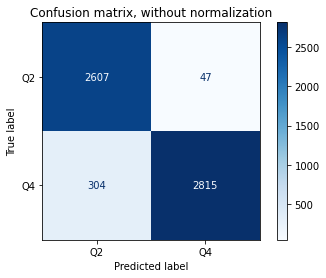

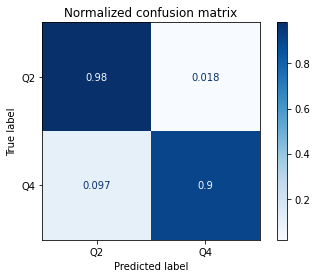

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names= ['Q2', 'Q4']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Applying Glove features:

In [39]:
from sklearn.ensemble import RandomForestClassifier

X_ =  pd.DataFrame(All.features.tolist())
y_ = All['target']

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_jobs=5, max_depth=13))])

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)


classifier = pipe.fit(X_train, y_train)

In [40]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.96      0.99      0.97      2654
           2       0.99      0.96      0.98      3119

    accuracy                           0.97      5773
   macro avg       0.97      0.98      0.97      5773
weighted avg       0.98      0.97      0.97      5773



Confusion matrix, without normalization
[[2624   30]
 [ 115 3004]]
Normalized confusion matrix
[[0.98869631 0.01130369]
 [0.03687079 0.96312921]]


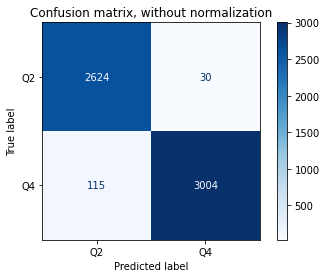

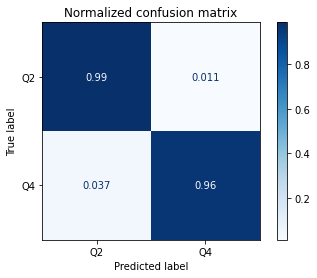

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names= ['Q2', 'Q4']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [43]:
pd.DataFrame(pipe.steps[1][1].feature_importances_).rename(columns={0:'gini'}).sort_values(by='gini', ascending=False)

,gini
60,0.086528
5,0.082685
19,0.070927
86,0.068172
63,0.059113
...,...
110,0.000891
118,0.000702
116,0.000622
115,0.000216
